# Embeddings

Basado en el capítulo 6 del libro "Deep Learning with Python" de Francois Chollet, 2018 Manning

# Parte 1. Representación de secuencias

Para poder analizar y procesar secuencias de términos (palabras, caracteres, señales, videos, series) es necesario primero definir el tipo de representación que se va a utilizar:
- **One hot encoding**: se utiliza un espacio de representación donde cada dimensión corresponde a uno de los posibles términos que se pueden encontrar en las secuencias. Cada término en una secuencia es entonces representado como un vector de muchísimos 0s, salvo por la dimensión que corresponde al término en sí. Esto crea problemas, pues este espacio es bastante disperso (muy pocos 1s), de muy alta dimensionalidad, y codificado "en duro" (la posición de cada término sigue un proceso arbitrario no basado en los datos en sí)
- **Embedding**: se utiliza un espacio de representación de dimensionalidad reducida, cuyo espacio está basado en una estructura estadística de la representación de los términos encontrados en las secuencias. En el caso de texto, la información de las relaciones de coocurrencia de las palabras se conserva a través de la distancia en el nuevo espacio de representación aprendido.

Una vez se define la representación de las secuencias, estas deben pasar por un proceso de separación en tokens (términos, palabras o caracteres, proceso de **tokenización**), que luego son transformados a una nueva representación vectorial (proceso de **vectorización**)

Las secuencias originales son entonces transformadas en tensores numéricos 2D: un eje para cada término, otro para el espacio de representación de cada token.

En el caso de los textos, la tokenización se puede hacer a nivel de palabras (cada palabra se transforma en un vector), a nivel de caracteres (cada caracter se transforma en un vector), o a nivel de n-gramas de palabras o caracteres (cada grupo de palabras o caracteres consecutivos y sobrelapados se transforma en un vector).

Los tensores numéricos de cada secuencia son enviados como inputs a la red de DL.



## One hot encoding

Si se tienen N tokens posibles (palabras o caracteres),
se considera un vector de N posiciones, donde cada posición representa un token determinado, y cada token es entonces representado como un vector con N-1 valores en 0 y un valor en 1 correspondiente a su posición dada.

Se podría implementar el one hot encoding en Python con *numpy*, pero lo mejor es aprovechar las funcionalidades incluidas en *Keras*:

In [2]:
import keras

Using TensorFlow backend.


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [4]:
import time

In [5]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Creamos un tokenizer, configurado para solo considerar las 20 palabras más comunes,
# (así aquí solo tengamos 9).
tokenizer = Tokenizer(num_words=20)
# Creamos el índice de palabras
tokenizer.fit_on_texts(samples)
# Veamos las palábras mas frecuentes
tokenizer.word_counts

OrderedDict([('the', 3),
             ('cat', 1),
             ('sat', 1),
             ('on', 1),
             ('mat', 1),
             ('dog', 1),
             ('ate', 1),
             ('my', 1),
             ('homework', 1)])

In [6]:
# Veamos el índice creado
print('Se encontraron %s tokens únicos.' % len(tokenizer.word_index))
print('El word_index es el diccionario con las palabras y sus índice correspondientes en el vocabulario')
tokenizer.word_index

Se encontraron 9 tokens únicos.
El word_index es el diccionario con las palabras y sus índice correspondientes en el vocabulario


{'the': 1,
 'cat': 2,
 'sat': 3,
 'on': 4,
 'mat': 5,
 'dog': 6,
 'ate': 7,
 'my': 8,
 'homework': 9}

Como ya se hizo la **tokenización**, podemos ahora realizar la **vectorización** de la secuencia de texto.

In [7]:
# Representación de los documentos a secuencias de índices
print('Cada texto (secuencia de palabras) se puede entonces representar como una secuencia de los índices correspondientes')
sequences = tokenizer.texts_to_sequences(samples)
sequences

Cada texto (secuencia de palabras) se puede entonces representar como una secuencia de los índices correspondientes


[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

Una variante del **one hot encoding** es el **hashing trick**, que se utiliza cuando el vocabulario es muy grande para asignar una posición a cada token dentro de un diccionario. 

En este caso se utiliza una función de hashing para crear un vector hash para cada token. 

El único posible problema sería la colisión de varios tokens con una misma representación de hashing; para limitar esta posibilidad, se utiliza un espacio de hashing mucho mayor que el número de tokens total.

In [8]:
import numpy as np
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Vamos a guardar las palabras como vectores de 20 posiciones.
# Si se tiene cerca de 20 palabras se tendrán muchas colisiones de hash, 
# y se reducirá la exactitud de este método de codificación.
dimensionality = 20
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # Con un hash, se transforma la palabra en un índice entero "aleatorio" entre 0 y 1000
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

In [9]:
# Veamos el segundo token de la primera palabra
results[0][1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

## Embeddings

Las dos maneras de usar los word embeddings son:
* **Aprendizaje**: Se aprende el espacio de representación al mismo tiempo que la tarea principal (predicción de sentimiento, clasificación de documento). En este caso, se parte de un vector de representación aleatorio, que es actualizado a medida que que se actualizan los pesos de la red neuronal durante el aprendizaje.
* **Transfer learning**: Se descarga una representación precomputada por un tercero. Se trata de word embeddings pre entrenados, usando algún otro proceso de machine learning, diferente al que se está tratando de resolver, aunque relacionado.


## Aprendizaje de word embeddings 

La manera mas sencilla de representar una palabra a partir de un vector es asignándole coordenadas aleatorias, pero el espacio resultante estaría desprovisto de cualquier idea de estuctura.
Se desea que las relaciones geométricas vectoriales entre embeddings de palabras representen sus relaciones semánticas.

En un buen embedding, se esperaría que sinónimos se encuentren cerca y en general que la distancia geométrica entre palabras esté relacionada con la distancia semántica. Además, las direcciones en el espacio tambien tienen un significado, las relaciones semánticas se codifican como transformaciones geométricas vectoriales (e.g. género, plural, tamaño).

No hay un embedding arquetípico perfecto del lenguaje humano; los embeddings dependen de la lengua y de la tarea para la cual se quiere utilizar. Un buen embedding para el analísis de sentimiento de reviews de películas no lo sería tanto para el análisis de documentos legales.

Es entonces razonable aprender un embedding para la tarea en cuestión. Keras lo permite a través del back propagation sobre capas *Embedding*.
Lo primero que se debe hacer es definir la capa Embedding, estableciendo el número de tokens máximo a considerar (e.g. máximo de palabras a considerar), y el número de dimensiones de los vectores de embedding.

In [10]:
from keras.layers import Embedding

# Número de palabras posibles (1000), dimensiones de los embeddings (64)
embedding_layer = Embedding(1000, 64)

La capa *Embedding* es un diccionario que mapea índices enteros de las palabras a los vectores correspondientes en el espacio de embedding, y recibe un dataset con muestras de texto codificadas en secuencias de los enteros correspondientes, de un largo determinado.
Todas las secuencias deben tener el mismo largo, por lo que secuencias más cortas van a ser completadas con ceros, y secuencias más largas deben ser cortadas.

Así, una capa embedding recibe un tensor 2D (samples, sequence_length) y producen un tensor 3D de salida (samples, sequence_length, embedding_dimensionality) con el array con la representación en el espacio de embedding.

### Embeddings de sentimientos de reviews de IMDB

Vamos a aprender un embedding a partir del dataset de reviews de IMDB.
Para simplificar la tarea, solo vamos a considerar las 10000 palabras mas frecuentes, y vamos a considerar solo las primeras 20 palabras de cada review para aprender embeddings en un espacio de 8 dimensiones.
El tensor de salida de los embeddings lo vamos a aplanar a un tensor 2D y lo vamos a alimentar a capas MLP densas para clasificar el sentimiento de las reviews correspondientes.


In [11]:
from keras.datasets import imdb
from keras import preprocessing

# Número de palabras a considerar
max_features = 10000
# Largo de la secuencia de representación de los reviews
#(solo se consideran las primeras 10000 palabras más frecuentes)
maxlen = 20

# Carga los datos como listas de enteros (los baja desde AWS)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [12]:
print("Reviews. train: ", x_train.shape, ", test: ", x_test.shape)
print("Labels. train: ", y_train.shape, ", test: ", y_test.shape)

Reviews. train:  (25000,) , test:  (25000,)
Labels. train:  (25000,) , test:  (25000,)


Se tienen 25000 documentos (reviews), con tamaños diferentes

In [13]:
print("Primera review: ", len(x_train[0]))
print("Sentimiento: ", y_train[0])

Primera review:  218
Sentimiento:  1


La primera review tiene 218 palabras, y corresponde al sentimiento 1 (de posibles 0 y 1)

In [14]:
# La review ya está codificada con los índices de los tokens. 
print('los primeros 20 índices de los tokens de la primera review son:', x_train[0][0:20])
print('los últimos 20 índices de los tokens de la primera review son:', x_train[0][198:218])

los primeros 20 índices de los tokens de la primera review son: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]
los últimos 20 índices de los tokens de la primera review son: [65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Vamos ahora truncar las secuencias para que queden todas con solo 20 términos, rellenando si se requiere.
Estas dos acciones, truncada y relleno, se pueden realizar al comienzo o al final de la secuencia.

In [15]:
# Convierte la lista de enteros a un tensor 2D con forma `(samples, maxlen)`
# conservando solo maxlen palabras, estas pueden escogerse ya sea al comienzo o al final de la secuencia
# El padding y el truncating se puede definir al principio o al final de la secuencia.
# Por defecto se realiza al comienzo (pre), por lo que solo quedan las últimas palabras.
x_train_pre = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_train_post = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen,
                                              padding='post', truncating='post')

Preferimos quedarnos con las últimas 20 palábras, que pueden llegar a ser más dicientes en las críticas, nos quedamos entonces con x_train_pre

Veamos como queda la primera review:

In [16]:
x_train_pre[0]

array([  65,   16,   38, 1334,   88,   12,   16,  283,    5,   16, 4472,
        113,  103,   32,   15,   16, 5345,   19,  178,   32])

Estos eran entonces los últimos 20 términos de la crítica.

Tenemos entonces que los datasets de entrenamiento y de evaluación del modelo son conjuntos de secuencias de 20 términos cada una, y que la variable dependiente que se quiere predecir es el sentimiento de la crítica (labels 0 o 1).

In [17]:
x_train= x_train_pre
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print("Reviews. train: ", x_train.shape, ", test: ", x_test.shape)
print("Labels. train: ", y_train.shape, ", test: ", y_test.shape)

Reviews. train:  (25000, 20) , test:  (25000, 20)
Labels. train:  (25000,) , test:  (25000,)


Vamos ahora a crear la capa de *Embedding*, a aplanarla, y a conectarla con una capa densa de clasificación con una sola neurona de salida.

In [18]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

In [19]:
model = Sequential()
# Especificamos el número de palabras a considerar (10000), el número de dimensiones 
# de los embeddings (8) y el largo máximo de la entrada (20), para luego aplanar los datos
model.add(Embedding(10000, 8, input_length=maxlen))
# Después de la capa de Embedding, la forma de los tensores es `(samples, maxlen, 8)`.
model.add(Flatten())
# Cuando los aplanamos, quedan como tensores 2D con forma `(samples, maxlen*8)`

# Agregamos el clasificador denso
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


Vamos ahora a entrenar el modelo, y con ello la capa del Embedding.

In [23]:
t_start = time.time()
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)
t_end = time.time()
print("Tiempo de entrenamiento: %2.2f minutos" % ((t_end - t_start)/60) )

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 30us/step - loss: 0.1456 - acc: 0.9484 - val_loss: 0.6866 - val_acc: 0.7238
Epoch 2/10
20000/20000 [==============================] - 1s 29us/step - loss: 0.1379 - acc: 0.9526 - val_loss: 0.7061 - val_acc: 0.7172
Epoch 3/10
20000/20000 [==============================] - 1s 31us/step - loss: 0.1303 - acc: 0.9552 - val_loss: 0.7229 - val_acc: 0.7176
Epoch 4/10
20000/20000 [==============================] - 1s 29us/step - loss: 0.1235 - acc: 0.9585 - val_loss: 0.7405 - val_acc: 0.7166
Epoch 5/10
20000/20000 [==============================] - 1s 30us/step - loss: 0.1174 - acc: 0.9607 - val_loss: 0.7591 - val_acc: 0.7138
Epoch 6/10
20000/20000 [==============================] - 1s 30us/step - loss: 0.1113 - acc: 0.9629 - val_loss: 0.7775 - val_acc: 0.7148
Epoch 7/10
20000/20000 [==============================] - 1s 29us/step - loss: 0.1058 - acc: 0.9648 - val_loss: 0.7955 - val_acc:

Obtenemos un accuracy de validación de 75%, bastante aceptable considerando que solo estamos teniendo en cuenta las últimas 20 palabras de cada review, y que consideramos las secuencias como sacos de palabras (*bag of words*) sin tener en cuenta su orden ni estructura de frase.

Sería mucho más útil agregar capas recurrentes o capas convolucionales 1D despues de la capa de embedding para aprender características que consideran la secuencia en su totalidad.

# Parte 2. Utilización de word embeddings pre entrenados

A veces no se cuenta con un set de entrenamiento lo suficientemente grande (e.g. corpus de textos) que permita aprender el embedding del vocabulario adecuado para la tarea en cuestión. En esos casos, en vez de aprender el embedding, se puede reutilizar otro embedding pre entrenado para otra tarea que haya logrado capturar aspectos genéricos del lenguaje; se trata de un tipo de **transfer learning**.

Estos embeddings no necesariamente se obtuvieron a partir de otros modelos de DL; pueden haber sido utilizados modelos basados en estadísticas de palabras (e.g. Word2Vec, GloVe).
Vamos a utilizar los embeddings de **GloVe** en el siguiente ejemplo.

### De texto plano a word embeddings

Vamos a rehacer el ejemplo de IMDB, pero esta vez empezando desde las reviews textuales, y considerando los embeddings de GloVe, que descargamos de http://mng.bz/0tIo http://ai.stanford.edu/~amaas/data/sentiment/ y de https://nlp.stanford.edu/projects/glove/

In [24]:
import os

t_start = time.time()

imdb_dir = 'D:/Usuarios/94501228/OneDrive - ICESI/Cursos_Propios/DL with Python/aclImdb'
#imdb_dir = '/home/icesi/Escritorio/Javier/Data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

# Recorremos dos subdirectorios, neg con los reviews negativos, pos con los reviews positivos
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        # Si el archivo termina con .txt se lee y se carga en la lista texts
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
t_end = time.time()
print("Tiempo de carga de mensajes en memoria: %2.2f minutos" % ((t_end - t_start)/60) )

Tiempo de carga de mensajes en memoria: 2.13 minutos


En labels quedan las etiquetas de sentimiento y en texts quedan los contenidos textuales de los 25000 reviews. Por ejemplo, veamos la primera review:

In [25]:
print("Label: ", labels[1], ", Texto: \"", texts[1], "\"")

Label:  0 , Texto: " Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public as a museum, also on board is Stevens daughter Julie (Kathleen Quinlan) & her son. The luxury jetliner takes off as planned but mid-air the plane is hi-jacked by the co-pilot Chambers (Robert Foxworth) & his two accomplice's Banker (Monte Markham) & Wilson (Michael Pataki) who knock the passengers & crew out with sleeping gas, they plan to steal the valuable cargo & land on a disused plane strip on an isolated island but while making his descent Chambers almost hits an oil rig in the Ocean & loses control of the plane sending it crashing into the sea where it sinks to the bottom right bang in the middle of the Bermuda Triangle. With air in short supply, water leaking in & having flown over 200 miles off course the

Ya con los reviews en memoria, se procede a su tokenización, dividiéndolos en training y test sets.

Como lo dijimos antes, los embeddings se aprenden específicamente con respecto a una tarea, y sólo vale la pena usarlos en transfer learning cuando no se tiene suficientes datos para aprender unos embeddings de calidad para la nueva tarea a aprender.

Así tengamos 25000 reviews, vamos a suponer que solo tenemos 200 reviews, que no serían suficientes para aprender un embedding, y a considerar 10000 reviews para validation.

In [28]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # Solo vamos a considerar solo 100 palabras de cada review
training_samples = 200  # Entrenaremos en solo 200 mensajes
validation_samples = 10000  # Validaremos en 10000 mensajes
max_words = 10000  # Solo consideraremos las 10000 palabras mas frecuentes

t_start = time.time()

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

t_end = time.time()
print("Tiempo de tokenización: %2.2f minutos" % ((t_end - t_start)/60) )

Tiempo de tokenización: 0.12 minutos


In [29]:
print("Número de reviews", len(sequences))
print("El segundo review tiene", len(sequences[1]), "palabras")

Número de reviews 25000
El segundo review tiene 724 palabras


In [30]:
word_index = tokenizer.word_index
print('Se encontraron %s tokens únicos.' % len(word_index))

Se encontraron 88582 tokens únicos.


Se truncan y paddean las secuencias:

In [31]:
data = pad_sequences(sequences, maxlen=maxlen)
data.shape

(25000, 100)

Ya cortamos los reviews para que sean secuencias de solo 100 palabras.

In [32]:
labels = np.asarray(labels)
print('tensor de los datos:', data.shape)
print('tensor de los labels:', labels.shape)

tensor de los datos: (25000, 100)
tensor de los labels: (25000,)


In [33]:
# Particionamiento del dataset en training y test set, después de reorganizar los reviews aleatoriamente.
# Esto es necesario pues los reviews están ordenados, quedando primero los negativos y luego los positivos.
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [34]:
print("Shape deL training set", x_train.shape)
print("Shape del test set", x_val.shape)


Shape deL training set (200, 100)
Shape del test set (10000, 100)


Tenemos al final un training set con 200 reviews, de 100 palabras cada uno.
Además, un test set con 10000 reviews, también de 100 palabras cada uno.

#### Se preprocesan los embeddings pre entrenados de GloVe
Vamos ahora a cargar en memoria el dataset GloVe 6B, que contiene un embedding de 100 dimensiones de 400,000 palabras, que se descargó desde https://nlp.stanford.edu/projects/glove/ (pesa 822 MB)

In [36]:
glove_dir = 'D:/Usuarios/94501228/OneDrive - ICESI/Cursos_Propios/DL with Python/glove6B'
#glove_dir = '/home/icesi/Escritorio/Javier/Data/glove6B'

t_start = time.time()

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

# Se lee el archivo línea por línea y se crea un diccionario con la palabra como key y 
# un array con los 100 valores del embedding como valor
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

t_end = time.time()
print("Tiempo de carga de los embeddings de cada palabra de GloVe: %2.2f minutos" % ((t_end - t_start)/60) )

Found 400000 word vectors.
Tiempo de carga de los embeddings de cada palabra de GloVe: 0.20 minutos


In [37]:
embeddings_index.get("the")

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

Ahora vamos a crear una matriz de embeddings que se cargará en una capa ``Embedding``, que será de la forma (max_words, 
embedding_dim), es decir de 10000 palabras x 100 dimensiones, dónde cada entrada contiene el vector de representación en el espacio 100-dimensional de la palabra correspondiente al índice dado en el word index, que se construyó durante la tokenización.
Por convención, el índice 0 se deja vació como placeholder para cualquier palabra.

In [39]:
embedding_dim = 100
# Se crea la matriz de los embeddings llena de ceros con las 10000 palabras mas frecuentes de los reviews.
embedding_matrix = np.zeros((max_words, embedding_dim))
# Se llena con los embeddings correspondientes que se sacan de los embeddings pre entrenados de GloVe.
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Si se encuentra la palabra en GloVe, se usa su vector 100-dimensional, sino, se deja todo en ceros.
            embedding_matrix[i] = embedding_vector

In [40]:
embedding_matrix[1]

array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

#### Se define el modelo neuronal

Se utiliza la misma arquitectura anterior, pero esta vez se carga en la primera capa, la del ``Embedding``, la matriz de pesos correspondientes a los valores sacados de GloVe, ya transformados en una matriz (un tensor) 2D, donde cada entrada es una vector que representa una palabra dada.


In [41]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# Inicialmente tenemos reviews representados en un tensor de rango 2D con las 100 palabras, cada una con 100 dimensiones
model.add(Flatten())
# Despues de aplanarlos reviews, cada uno queda con una representacion de un tensor 1D de 100x100=10000 
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


Se establece que los parámetros del embedding no se van a cambiar durante el entrenamiento, pues los gradientes producidos al entrenar las capas siguientes, incializadas aleatoriamente, serían muy grandes y dañarían las representaciones de los embeddings.

In [42]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Compilamos el modelo y entrenamos las capas MLP con 50 épocas.

Al final, guardamos los pesos del modelo en un archivo H5

In [43]:
t_start = time.time()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

t_end = time.time()
print("Tiempo de entrenamiento del clasificador con GloVe: %2.2f minutos" % ((t_end - t_start)/60) )

Train on 200 samples, validate on 10000 samples
Epoch 1/50
200/200 [==============================] - 1s 4ms/step - loss: 1.3738 - acc: 0.5600 - val_loss: 0.8096 - val_acc: 0.4914
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.6942 - acc: 0.6400 - val_loss: 0.6845 - val_acc: 0.5512
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4749 - acc: 0.7550 - val_loss: 0.6870 - val_acc: 0.5588
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4076 - acc: 0.8150 - val_loss: 1.1229 - val_acc: 0.4918
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.2949 - acc: 0.8800 - val_loss: 0.7700 - val_acc: 0.5419
Epoch 6/50
200/200 [==============================] - 1s 3ms/step - loss: 0.1979 - acc: 0.9400 - val_loss: 0.7356 - val_acc: 0.5507
Epoch 7/50
200/200 [==============================] - 1s 4ms/step - loss: 0.1067 - acc: 0.9850 - val_loss: 0.9458 - val_acc: 0.5089
Epoch 8/50
200/200 [========

Analicemos cómo evolucionó el modelo durante el entrenamiento.

In [44]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

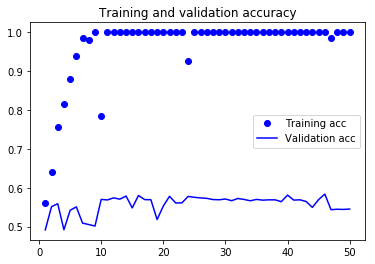

In [45]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

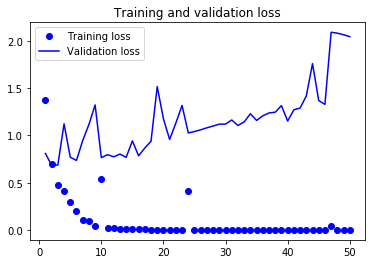

In [46]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Vemos que el modelo comienza a presentar **overfitting** rápidamente, lo que no es una sorpresa, dado el pequeño número de ejemplos de entrenamiento. El accuracy de validación tiene una varianza importante, por la misma razón, logrando alcanzar valores cercanos al 58%.

El performance puede cambiar drásticamente, dependiendo altamente de los 200 mensajes específicos que se escogieron en el training set.

También podemos intentar entrenar el mismo modelo sin utilizar los embeddings pre-entrenados y sin congelar la capa de ``Embedding``. En ese caso, estaríamos aprendiendo un embedding específico a la tarea de clasificación final, lo que en general es más poderoso que los embeddings pre-entrenados, cuando se tiene un training set grande (no uno con solo 200 ejemplos). Veamos:

In [48]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

t_start = time.time()

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val))

t_end = time.time()
print("Tiempo de entrenamiento del clasificador desde cero: %2.2f minutos" % ((t_end - t_start)/60) )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/50
200/200 [==============================] - 1s 6ms/step - loss: 0.6942 - acc: 0.5350 - val_loss: 0.6935 - val_acc: 0.5015
Epoch 2/50
200/200 [==============================] - 1s 4ms/step - loss: 0.5122 - a

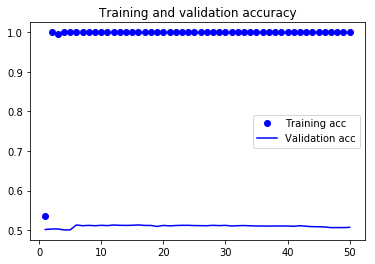

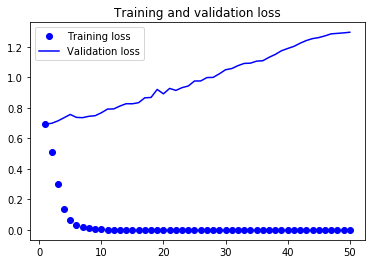

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


En este caso el accuracy de validación llega a los valores llegan alrededor de 52.5%. Por lo que podemos concluir que en este caso particular, utilizando embeddings pre-entrenados se logra un mejor rendimiento que aprendiéndolos desde cero al mismo tiempo que la tarea de clasificación final.
Si se aumenta el training set, esto puede cambiar.

Finalmente, vamos a evaluar el modelo con el test set y con el modelo que incluye los embeddings pre-entrenados, cuyos pesos guardamos en un archivo h5.

In [51]:
t_start = time.time()

test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

t_end = time.time()
print("Tiempo de carga del test set: %2.2f minutos" % ((t_end - t_start)/60) )

Tiempo de carga del test set: 1.35 minutos


In [52]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 63us/step


[2.0224194637715818, 0.55032]

Obtenemos solamente 56% de accuracy, muy cerca del baseline. Trabajar con tan pocos ejemplos de entranamiento es muy difícil!

#### Utilización de 20000 reviews de entrenamiento y pesos pre-entrenados

Se hizo el mismo ejercicio con 20000 reviews en el training set con los embedding pre-entrenados.

In [53]:
maxlen = 100  # We will cut reviews after 100 words
training_samples = 20000  # We will be training on 20000 samples
validation_samples = 5000  # We will be validating on 5000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 87393 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


Tenemos al final un training set con 20000 reviews, de 100 palabras cada uno.
Además, un test set con 10000 reviews, también de 100 palabras cada uno.

In [54]:
x_train.shape

(20000, 100)

In [55]:
x_val.shape

(5000, 100)

Ya teníamos los embeddings preciamente cargados con las 10000 palabras mas frecuentes, representadas en 100 dimensiones.

In [56]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector            

In [57]:
embedding_matrix.shape

(10000, 100)

Redefinimos el mismo modelo neuronal y lo entrenamos

In [58]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [61]:
t_start = time.time()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model_2000_reviews.h5')

t_end = time.time()
print("Tiempo de entrenamiento del clasificador desde cero: %2.2f minutos" % ((t_end - t_start)/60) )

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 5s 236us/step - loss: 0.6439 - acc: 0.6403 - val_loss: 0.5600 - val_acc: 0.7214
Epoch 2/50
20000/20000 [==============================] - 6s 298us/step - loss: 0.5144 - acc: 0.7503 - val_loss: 0.5478 - val_acc: 0.7218
Epoch 3/50
20000/20000 [==============================] - 5s 259us/step - loss: 0.4598 - acc: 0.7856 - val_loss: 0.5655 - val_acc: 0.7166
Epoch 4/50
20000/20000 [==============================] - 4s 222us/step - loss: 0.4170 - acc: 0.8080 - val_loss: 0.5546 - val_acc: 0.7320
Epoch 5/50
20000/20000 [==============================] - 5s 237us/step - loss: 0.3839 - acc: 0.8260 - val_loss: 0.5816 - val_acc: 0.7182
Epoch 6/50
20000/20000 [==============================] - 4s 217us/step - loss: 0.3502 - acc: 0.8447 - val_loss: 0.6587 - val_acc: 0.7034
Epoch 7/50
20000/20000 [==============================] - 4s 215us/step - loss: 0.3199 - acc: 0.8605 - val_loss: 0.6334 - v

Analicemos cómo evolucionó el modelo durante el entrenamiento.

In [62]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

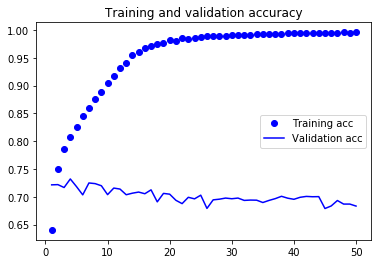

In [63]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

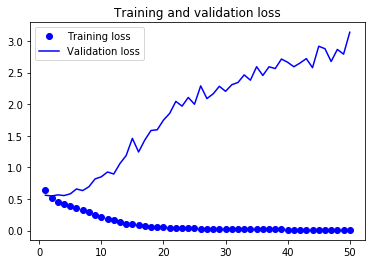

In [64]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Vemos que el modelo comienza a presentar **overfitting** rápidamente.
Despuès de la primera decena de iteraciones encontramos un aumento importante en la función de pérdida del set de validación. En el punto óptimo, alcanzamos un accuracy de validación de alrededor de 72%